# Covid-19 Data Analysis


# 0. Introduction

The purpose of this project is to use python to explore, clean, and draw some insights from the John's Hopkins Covid-19 dataset (sourced from dataworld: https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker) and the COVID-19 State and County Policy Orders dataset (sourced from data.gov: https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders). 

This notebook is divided into 3 sections:

1) data cleaning

2) data visualization

3) correlation between cases and policies

### important notes: 
- When investigating the new case and death numbers by location, we will control for county / state population by reporting these figures per 100,000 people. I will be referring to these as the *normalized* values. 

- An extended discussion of the data cleaning can be found [here](https://github.com/apalermo01/covid-19-data-analysis/blob/main/Covid-19_data_cleaning.ipynb.)

In [2]:
%reset -f
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import datetime
import re
from tabulate import tabulate
from IPython.display import clear_output

# handle state metadata (source: https://github.com/unitedstates/python-us)
import us

# 1 Data Cleaning

First, we load each of the datasets. df is the cases data, df2 is the policy data. 
The covid-19 case and death dataset is queried directly from dataworld, the policy datset is pulled from a local file. 

In [3]:
df  = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')

C:\Users\Alex\anaconda3\envs\covid_project\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [8]:
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,NY,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,NaN
1,DE,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
2,FL,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,MI,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,NaN
4,NE,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,NaN


## 1.1 John's Hopkins Covid-19 dataset

First shorten some column names

In [9]:
df.rename(columns={
    'cumulative_cases_per_100_000': 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000': 'cumulative_deaths_1e6',
    'new_cases_per_100_000': 'new_cases_1e6', 
    'new_deaths_per_100_000': 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg': 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg': 'new_deaths_7day'
    
}, inplace=True)

Investigate how this data is distributed and look for errors. 

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Check the distribution of numerical fields

In [10]:
df.describe()

,uid,fips_code,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
count,1.114224e+06,1.110884e+06,1.075480e+06,1.114224e+06,1.075480e+06,1.114224e+06,1.075480e+06,1.110888e+06,1.110888e+06,1.072260e+06,1.072260e+06,1.094134e+06,1.096894e+06
mean,8.352961e+07,3.310136e+04,1.013323e+05,1.356240e+03,1.248701e+03,3.864981e+01,2.610686e+01,1.605514e+01,2.858290e-01,1.773105e+01,3.069882e-01,1.588789e+01,3.001752e-01
std,3.206731e+06,1.861217e+04,3.260459e+05,7.442895e+03,1.947116e+03,2.526583e+02,4.880848e+01,1.045902e+02,5.403576e+00,5.184871e+01,2.336689e+00,8.967723e+01,2.319336e+00
min,6.307200e+07,1.001000e+03,7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.590000e+03,-3.962000e+03,-5.975850e+03,-1.653200e+02,0.000000e+00,0.000000e+00
25%,8.401811e+07,1.908500e+04,1.121425e+04,1.000000e+00,1.082000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.402921e+07,3.101800e+04,2.595050e+04,6.900000e+01,3.242100e+02,1.000000e+00,3.270000e+00,1.000000e+00,0.000000e+00,1.410000e+00,0.000000e+00,1.290000e+00,0.000000e+00
75%,8.404612e+07,4.713300e+04,6.655225e+04,5.540000e+02,1.729155e+03,1.100000e+01,3.202000e+01,7.000000e+00,0.000000e+00,1.748000e+01,0.000000e+00,7.670000e+00,1.400000e-01
max,8.410000e+07,9.999900e+04,1.009805e+07,6.236700e+05,2.802842e+04,8.875000e+03,7.636500e+02,2.223600e+04,1.553000e+03,9.370100e+03,2.793300e+02,1.402629e+04,2.445700e+02


Check the datatypes and number of nulls. df.info() will also give the datatypes, however non-numeric data is cast to 'object' and we want to be more specific.

In [12]:
def eval_df(df):
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  --------------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                     3340  {<class 'numpy.float64'>}
location_name                  668  {<class 'float'>, <class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population             38744  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6         38744  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6        38744  {<class 'numpy.float64'>}
new_cases                     3336  {<class 'numpy.float64'>}
new_deaths                    3336  {<class 'numpy.float64'>}
new_cases_1e6                41964  {<class 'numpy.float64'>}
new_deaths_1e6               41964  {<class 'n

While inspecting these tables a few issues become apparent: 

1) null values several columns

2) some fields that should be integers are floats (total_population, new_cases, new_deaths)

3) some values for location_name are floats

4) negative values in new_cases, new_deaths, and their normalized equivalents 

We can likely eliminate some of these issues by throwing out some locations. We'll throw out any locations where 'location_type' is not 'county' and any datapoints that are not in the 50 states. 

In [13]:
df = df.drop(df[df['location_type']!='county'].index)
states = [elem.name for elem in us.states.STATES]
df = df.drop(df[~df['state'].isin(states)].index)

In [14]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  -------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.float64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population                 0  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                     3141  {<class 'numpy.float64'>}
new_deaths                    3141  {<class 'numpy.float64'>}
new_cases_1e6                 3141  {<class 'numpy.float64'>}
new_deaths_1e6                3141  {<class 'numpy.float64'>}
new_case

Restricting locations had the effect of throwing out nulls in fips_code, location_name, total_poplulation, cumulative_cases_1e6, and cumulative_deaths_1e6. 

The nulls in new_cases(\_1e6) and new_deaths(\_1e6) all occur on 2020-01-22, the first day on which reporting occurs, so we can set these to zero.  

In the 7 day running averages, many of these nulls occur in the first 5 days. There are some others distrubuted throughout the dates. we can set those to zero as well. 

In [17]:
df['new_cases'].fillna(value=0, inplace=True)
df['new_deaths'].fillna(value=0, inplace=True)
df['new_cases_1e6'].fillna(value=0, inplace=True)
df['new_deaths_1e6'].fillna(value=0, inplace=True)

df['new_cases_7day'].fillna(value=0, inplace=True)
df['new_deaths_7day'].fillna(value=0, inplace=True)

## 1.1.2 Handling negative values

new_cases and new_deaths seem to have many negative values. See the dedicated data cleaning notebook for more detailed information. negative numbers are very big in some cases. Highlight findings, maybe make 1 or 2 small plots talking about the distribution of these negative values. 

On the disucssion page for this dataset in dataworld (https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) user nickyforester adressed the negative values in new_cases and new_deaths with: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

As these are simply errors, I'll change them to zero. 

In [17]:
df['new_cases'].clip(lower=0, inplace=True)
df['new_deaths'].clip(lower=0, inplace=True)
df['new_cases_1e6'].clip(lower=0, inplace=True)
df['new_deaths_1e6'].clip(lower=0, inplace=True)

## 1.1.3 Handling datatypes

First, convert date from string to datetime

In [18]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

fips_code, total_population, new_cases, and new_deaths should be integers. Check that there are actually no decimal components, then convert to ints

In [19]:
cols = ["fips_code", "total_population", "new_cases", "new_deaths"]
print("all values integers? ")
for col in cols: 
    all_ints = all([i.is_integer() for i in df[col].values])
    print(f"{col}: {all_ints}")

all values integers? 
fips_code: True
total_population: True
new_cases: True
new_deaths: True


In [20]:
df[cols] = df[cols].astype(np.int64)

Finally, make a new column with full location name (county, state) and convert location_name to lowercase

In [21]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df['location_name'] = df['location_name'].str.lower()

## 1.1.4 normalized rolling averages

Finally, calculate 2 new columns for the 7 day rolling average per 100,000 people

In [22]:
df["new_cases_7day_1e6"]  = df['new_cases_7day']   /(df['total_population']/1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] /(df['total_population']/1e5)

Re-check the data to see if there are any missed issues

In [23]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  ----------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.int64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'numpy.datetime64'>}
total_population                 0  {<class 'numpy.int64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                        0  {<class 'numpy.int64'>}
new_deaths                       0  {<class 'numpy.int64'>}
new_cases_1e6                    0  {<class 'numpy.float64'>}
new_deaths_1e6                   0  {<class 'numpy.float64'>}


## 1.2 Covid policy data

Check column names

In [24]:
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')
df2.columns

Index(['state_id', 'county', 'fips_code', 'policy_level', 'date',
       'policy_type', 'start_stop', 'comments', 'source', 'total_phases'],
      dtype='object')

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| state_id | state name | string
| county | county name (this should be the same as county in df) | string, county name for county level policies "statewide" for state policies
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| policy_level | scope of policy | string, 'county' or 'state
| date | date of policy implementation | datetime object
| policy_type | brief description of policy classification | datetime object
| start_stop | whether this is the start of a restriction or lifting of a restriction | positive integer
| comments | additional information | string
| source | source for policy info | string
| total_phases | total number of phases | positive integer

Since this is mostly text-based data, we'll skip .describe()

In [25]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1646  {<class 'float'>, <class 'str'>}
fips_code            1646  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2819  {<class 'numpy.float64'>}


Start by dropping policies not implemented in the 50 states and converting state abbreviations to full name.

In [26]:
abbr = [elem.abbr for elem in us.states.STATES]
df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)

Aditionally, we can drop total_phases since we won't be using it in the analysis

In [27]:
df2.drop('total_phases', axis=1, inplace=True)

In [28]:
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source
0,New York,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...
1,Delaware,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
2,Florida,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
3,Michigan,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...
4,Nebraska,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual


## 1.2.1 Handling nulls

Nulls in 'county' are most likely statewide policies. Check this by looking for null values in 'county' where 'policy_level' is NOT statewide 

In [29]:
df2[(df2['policy_level']!='state') & (df2['county'].isnull())]

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source


Evidently, there are no unusual cases where 'policy_level' is not statewide while 'county' is still null. We can change 'county' to say 'statewide' for state-level policies and convert them to lowercase.

In [30]:
df2['county'].fillna(value='statewide', inplace=True)
df2['county'] = df2['county'].str.lower()

Let's make sure all the county names in df2 also appear in df

In [31]:
locs = df['location_name'].unique()
mismatches = lambda df, locs: [county for county in df['county'][df['policy_level']!='state'].unique() 
                                if county not in locs]
print(f"number of mismatches: {len(mismatches(df2, locs))}")
print(f"{mismatches(df2, locs)[:5]}")


number of mismatches: 289
['frio county', 'osage county', 'colusa county', 'erie county', 'greene county']


There appear to be many mismatches, and the first 5 in the list end with 'county', so let's drop the 'county' from every location name.

In [32]:
county_match    = re.compile(" county$")
df2['county'].replace(to_replace= county_match, value='', inplace=True)
mismatches(df2, locs)

['skagway municipality', 'haines borough', 'anchorage municipality']

now handle the last few odd ones

In [33]:
munici_match    = re.compile(" municipality$")
Borough_match   = re.compile(" borough$")

df2['county'].replace(to_replace= munici_match, value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

mismatches(df2, locs)

[]

Similar to county, nulls in fips_code likely relate to statewide policies. Do the same check to verify this. 

In [34]:
df2[(df2['fips_code'].isnull()) & (df2['policy_level']!='state')]

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source


Replace these nulls with the actual 2 digit fips code for the state.

In [35]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state': 
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state_id).fips)

## 1.2.2 Handling datatypes

This is relatively simple, all we need to do is convert fips_code to integers (after checking that all decimal components are zero) and convert date to datetime

In [36]:
fips_code_ints = any([~i.is_integer() for i in df2['fips_code'].values])
print(f"fips_code: all decimal components zero? (expect true) {fips_code_ints}")

fips_code: all decimal components zero? (expect true) True


In [37]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')
df2['fips_code'] = df2['fips_code'].astype(np.int64)

## 1.2.3 policy_types

Let's examine all the policy types in this dataset

In [38]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

Some of these names are a bit too long. Rename any policy type longer than 40 characters, then convert all of them to lowercase

In [39]:
long_names = [policy for policy in df2['policy_type'].unique() if len(policy)>40]
for i in long_names: 
    print(i)

Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval
Allow Expand Medicaid Telehealth Coverage
Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues
Mandate Face Mask Use By All Individuals In Public Spaces
Mandate Face Mask Use By All Individuals In Public Facing Businesses
Reopened ACA Enrollment Using a Special Enrollment Period
Suspended Elective Medical Dental Procedures
Stop Initiation Of Evictions Overall Or Due To Covid Related Issues
Renter Grace Period Or Use Of Security Deposit To Pay Rent


In [40]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues': 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval': 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues': 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses':  'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces': 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period': 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures': 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage': 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent': 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)

long_names = [policy for policy in df2['policy_type'].unique() if len(policy)>40]
if len(long_names) == 0: 
    print("no more long names")

no more long names


In [41]:
df2['policy_type'] = df2['policy_type'].str.lower()

Some of these policies are also vague and non-specific, so we'll drop these as well 

In [42]:
policies_drop = ["phase 1", "phase 2", "phase 3", "phase 4", "phase 5", "new phase"]
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

check the range of dates

In [43]:
max_date = max(df2['date'])
min_date = min(df2['date'])
print(f"max date: {max_date}; min date: {min_date}")

max date: 2020-12-31 00:00:00; min date: 1899-12-30 00:00:00


Drop policies that were enacted before the first date in the case dataset and policies scheduled in the future

In [44]:
df2 = df2.drop(df2[(df2['date']<min(df['date'])) | (df2['date']>datetime.datetime.today())].index)

Do a final check to verify that we're done. 

In [45]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  ----------------------------
state_id                0  {<class 'str'>}
county                  0  {<class 'str'>}
fips_code               0  {<class 'numpy.int64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'numpy.datetime64'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}


# 2. Data visualizations

# 2.1 New cases and deaths

Here, we'll write a few functions that plot data at the county, state, and national levels. 

In [46]:
def get_cases(level="county", county="orange", state="California", df=df):
    
    """ Return the new_case and new_death numbers at the given level of aggregation (county, state, or national). 
    inputs:  
    level  -- "county" [default] - get county level data
              "state" - get state level data
              any other input - get national level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, df by default
    
    return: 
    dataFrame -- case_data filtered to a specific county with index=date
    """
    # return county level data
    if level == "county":
        return_df = df[(df["location_name"]==county) & (df["state"]==state)].set_index("date")[['new_cases_1e6', 
                                                                                                'new_deaths_1e6', 
                                                                                                'new_cases_7day_1e6', 
                                                                                                'new_deaths_7day_1e6']]
        if 'case_vel' in df.columns: 
            return_df['case_vel'] = df[(df["location_name"]==county) & (df["state"]==state)]['case_vel']
            return_df['case_accel'] = df[(df["location_name"]==county) & (df["state"]==state)]['case_accel']
            return_df['death_vel'] = df[(df["location_name"]==county) & (df["state"]==state)]['death_vel']
            return_df['death_accel'] = df[(df["location_name"]==county) & (df["state"]==state)]['death_accel']
        return return_df
    # if this is filtered at the state level, filter df to desired state. Otherwise, return national-level data
    if level=="state": 
        df = df[df['state'] == state]

    # reindex on location name
    df = df.set_index(["full_loc_name"])
    
    # get a list of all dates
    all_dates = df['date'].unique()

    # get the total population from the county populations
    total_population =  sum([(pops/1e5) for pops in df[df['date']==all_dates[0]]['total_population']]) 
    
    # add up the case and death #s that have the same date
    new_cases       = [sum([(county_cases/total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_1e6' ]]) 
                              for dates in all_dates]

    new_deaths      = [sum([(county_cases/total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                              for dates in all_dates]

    new_cases_7day  = [sum([(county_cases/total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_7day_1e6'   ]]) 
                              for dates in all_dates]

    new_deaths_7day = [sum([(county_cases/total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_7day_1e6'  ]]) 
                              for dates in all_dates]


    return_df = pd.DataFrame(data={'date'    : all_dates,
                        'new_cases_1e6'  : new_cases, 
                        'new_deaths_1e6' : new_deaths,
                        'new_cases_7day_1e6'    : new_cases_7day,
                        'new_deaths_7day_1e6'   : new_deaths_7day
                        }).set_index(["date"]) 
    return return_df

In [47]:
def plot_cases(level="county", county="orange", state="California", df=df, fade=0.75, style="whitegrid", title=None):
    
    """ A function which plots the COVID-19 case/death data and 7 day average
    inputs: 
    level  -- "county" [default] - plot county level data
              "state" - plot state level data
              "national" - plot total number of new cases and new deaths in the united states
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    style  -- sns plot style
    
    return: 
    [fig, ax] -- figure and axis handles, respectively, for the generated plot
    """
    
    # get the data
    cases = get_cases(level, county, state, df)
        
    # plot the data
    fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    
    sns.set_style(style)
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
    );

    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
    );
    
    # format and title axes
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}");
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}");
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States")
    
    
    return fig, ax, cases

Plot the cases at a few different levels

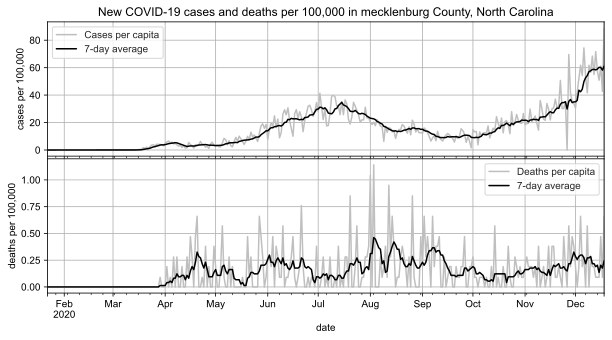

In [48]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

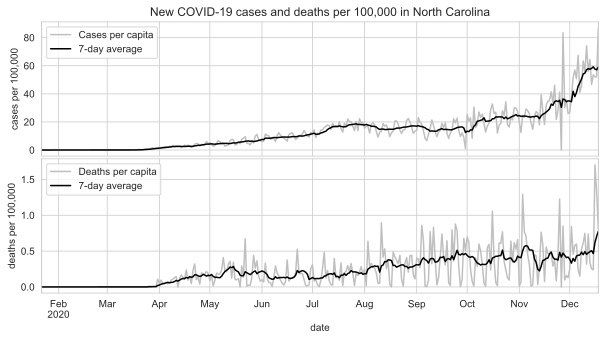

In [49]:
plot_cases(level="state", state="North Carolina");

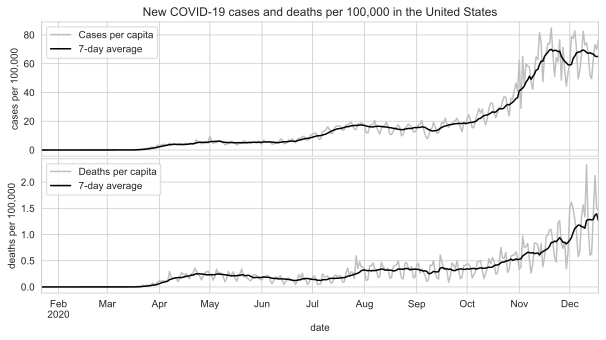

In [50]:
plot_cases(level="national");

# 2.2 Policy data overlay

First, we'll get the policy data for a specific county at the state level, county level, or both. Then, make a plot that overlays policy enactments and case / death numbers with a few selected policies. 

In [51]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
   
    """ A function which returns the policy data at either the state level, county level, or both
    inputs: 
    state -- selected state
    county -- selected county
    state_policies -- include policies at the state level
    county_policies -- include policies at the county level
    
    return: 
    filtered DataFrame
    """
    # state AND county policies
    if state_policies and county_policies:

        return df[(df['state_id'] == state) &
                  ((df["county"] == county) | (df["county"] == "statewide"))]
    
    # state policies only
    elif state_policies and not county_policies: 
        return df[ (df['state_id'] == state) & (df["county"] == "statewide")]
    
    # county policies only
    else:  
         return df[ (df['state_id'] == state) & (df["county"] == county)]

In [52]:
def plot_case_and_policies(county, state, title=None, style="whitegrid", colors=['k', 'b', 'r', 'g'],  
    policies=[
        "mandate face masks in public spaces", 
        "mandate face masks in businesses", 
        "shelter in place", 
        "state of emergency"],
                           
    labels=["face mask mandate (public spaces)", 
         "face mask mandate (businesses)", 
         "shelter in place", 
         "state of emergency"], 
    fade=0.75):

    
    """Plot the cases overlayed with the policies. 
    inputs: 
    county   -- county of interest
    state    -- state of interest
    policies -- policies to plot
    colors   -- line colors for respective policies (in order)
    labels   -- legend labels for the selected policies
    style    -- sns plot style
    
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    """
    
    # plot case / death data
    plt.figure();
    fig, ax, df = plot_cases(level="county", county=county, state=state, fade=fade, style=style, title=title);
    

    # get the policy data for the selected state and county 
    policy_data = get_policy_data(state, county);

    # set a solid line to be the start of a policy and a dashed line to be the end
    styles_start_stop = {
        "start": '-', 
        "stop": ':'
    }

    # set color codes for selected policies
    styles_policy_type = {policies[i]: colors[i] for i in range(len(policies))}
    
    # set labels for legend
    legend_policy_labels = {policies[i]: labels[i] for i in range(len(policies))}
    
    # define parameters
    legend_position=(1, 1) # anchor for legend positioning
    line_split = 0
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # loop axes
    for i in range(2):
        
        # expland y axis to get some extra room on the bottom
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # loop through policies
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # get the y-positional coordinate for the line on the selected day (between 0 and 1) 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # calculate where to position the line horizontally 
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1- but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly 

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # split the mark if there are multiple policies enacted on the same day 
            if num_policies > 1: 
                hmin = (cent_coord-mark_length/2) + line_split * (mark_length/num_policies)
                hmax = (cent_coord+mark_length/2) - \
                    (mark_length/num_policies) + ((line_split*mark_length)/num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord-mark_length/2)
                hmax = (cent_coord+mark_length/2)
                line_split=0
                
            # plot the mark
            line = ax[i].axvline(x=row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax)

             
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
            if row.policy_level == "state":
                line.set_marker('d')
            else: 
                line.set_marker('o')
            ax[i].legend(loc = "upper left")
        
    # make legend
    legend_lines = []
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label = "state policy"))
    
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label = "county policy"))
    
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # draw legend
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, bbox_to_anchor=legend_position)
    ax[0].add_artist(leg1)
            
    return ax

<Figure size 432x288 with 0 Axes>

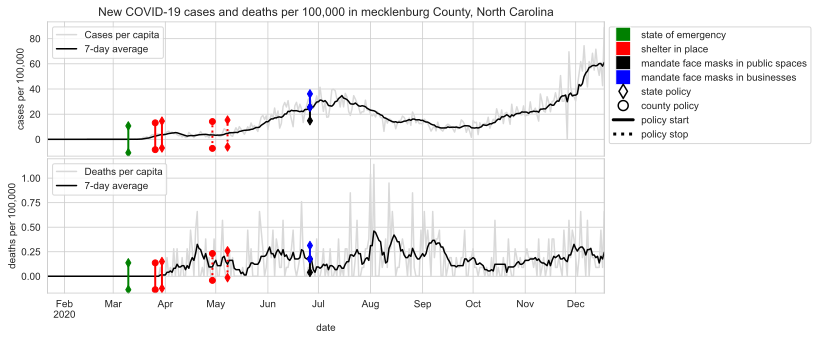

In [53]:
plot_case_and_policies("mecklenburg", "North Carolina", fade=0.85);

<Figure size 432x288 with 0 Axes>

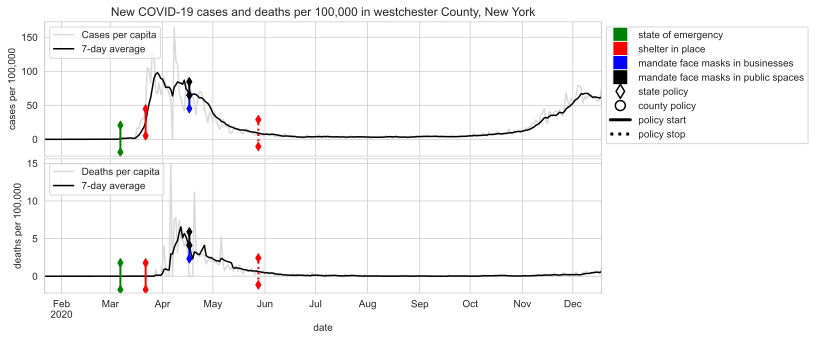

In [54]:
plot_case_and_policies("westchester", "New York", fade=0.85);

# 3. Connecting case numbers and covid policies

# 3.1 
Next, we'll start to examine the correlation between case / death numbers and policies. 

First, we need to calculate the change in the number of new cases at the point of a policy implementation and 14 days afterward. Aditionally, we'll find the the curvature after a given policy implementation. 

In [55]:
def calculate_deltas(measure_period=14, filtered_policies=None, case_df=df, policy_df=df2): 
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    inputs: 
    measure_period    -- time to wait
    filtered_policies -- selected policies to select
    
    returns: 
    A copy of the df (covid policies) dataframe with 2 appended columns for the change in case and death numbers. 
    """
    # initialize wait period before measurement
    wait_period = datetime.timedelta(days=measure_period)
    day_1 = datetime.timedelta(days=1)
    
    def sub_calc_deltas(ser, date, wait=wait_period): 
        day_1 = datetime.timedelta(days=1)
    
        start      = ser[ser.index==date].values[0]
        start_1day = ser[ser.index==date+day_1].values[0]
        
        end        = ser[ser.index==date+wait].values[0]
        end_1day   = ser[ser.index==date+wait+day_1].values[0]
        
        return [start, start_1day, end, end_1day]
    
    # If there we are only examining select policies, then filter those out
    if filtered_policies is not None: 
        policy_df = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        
    correlated_df = policy_df.copy()
    
    # initially fill the delta column with nan
    correlated_df.loc[:, f"case_{measure_period}_day_delta"]  = np.nan
    correlated_df.loc[:, f"case_{measure_period}_day_accel"]  = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    # load all state-aggregated datasets into a dictionary
    state_cases_dict = dict()
    for state in [elem.name for elem in us.states.STATES]: 
        state_cases_dict[state]=get_cases(level="state", state=state);

    case_df = case_df.set_index('date')
    total_policies = len(policy_df)
    for index, data in policy_df.iterrows(): 
  
        if data.policy_level == 'state': 
            state_df = state_cases_dict[data.state_id]
            ser_cases  = state_df['new_cases_7day_1e6' ]
            ser_deaths = state_df['new_deaths_7day_1e6']
            
        else:
            ser_cases  = case_df['new_cases_7day_1e6' ][case_df['fips_code']==data.fips_code]
            ser_deaths = case_df['new_deaths_7day_1e6'][case_df['fips_code']==data.fips_code]
        
        c11, c12, c21, c22 = sub_calc_deltas(ser_cases, date=data.date)
        d11, d12, d21, d22 = sub_calc_deltas(ser_deaths, date=data.date)
       
        correlated_df.at[index, f"case_{measure_period}_day_delta"]  = c21 - c11
        correlated_df.at[index, f"death_{measure_period}_day_delta"] = d21 - d11
        correlated_df.at[index, f"case_{measure_period}_day_accel"]  = ((c12-c11) - (c21-c22)) / measure_period
        correlated_df.at[index, f"death_{measure_period}_day_accel"] = ((d12-d11) - (d21-d22)) / measure_period    
    
    return correlated_df

In [56]:
policy_deltas = calculate_deltas()
policy_deltas.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,New York,bronx,36005,county,2020-06-08,non-essential businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,-2.443889,-0.024838,-0.457621,0.000745
1,Delaware,statewide,10,state,2020-03-27,modify medicaid requirements,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,3.739756,0.040141,0.016256,0.006992
2,Florida,statewide,12,state,2020-03-18,expand medicaid telehealth coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,0.537028,0.011618,0.013632,0.000377
3,Michigan,delta,26041,county,2020-07-31,entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,2.348715,0.112501,0.000000,0.000000
4,Nebraska,box butte,31013,county,2020-03-30,shelter in place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,1.262512,0.000000,0.000000,0.000000


Next, calculate the average deltas for each kind of policy implementation. 


In [57]:
def calc_delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    inputs: 
    deltas         -- dataframe of policy deltas on which to do the calculations
    measure_period -- how long to wait before measuring the effect of the policy
    min_samples    -- minimum number of samples that a policy must have for reporting of average and std
    
    returns: 
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """

    # generate a new list of policy types differentiating between start and stop 
    policy_types = ([elem+" - start" for elem in deltas['policy_type'].unique()] + 
                    [elem+" - stop"  for elem in deltas['policy_type'].unique()])
    
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    # loop through all the policy types
    for policy in policy_types:
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
            
        case_data  = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'case_{measure_period}_day_accel']
        
        death_accel_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))

        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # construct the dataframe to tabulate the data
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index = policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # drop record with less than min_samples samples
    delta_stats.drop(delta_stats[delta_stats['num_samples']<=min_samples].index, inplace=True)
    
    return delta_stats

In [58]:
delta_stats = calc_delta_stats(deltas=policy_deltas)
delta_stats.head()

<ipython-input-57-ed9e408e9a06>:43: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-57-ed9e408e9a06>:44: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-57-ed9e408e9a06>:49: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-57-ed9e408e9a06>:50: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
non-essential businesses - start,3.785881,0.103054,-0.044662,-0.000602,13.967747,0.645575,0.476263,0.023593,138.0
modify medicaid requirements - start,3.446992,0.020910,0.132362,0.001461,4.667520,0.046826,0.257465,0.003396,50.0
expand medicaid telehealth coverage - start,2.571533,0.018312,0.107111,0.001127,2.741261,0.050240,0.215875,0.003970,49.0
entertainment - start,2.899605,-0.005164,-0.027472,-0.001294,12.341734,0.246113,0.509189,0.025839,122.0
shelter in place - start,2.799337,0.024910,0.087632,0.001377,8.008662,0.180714,0.248363,0.005889,454.0


The "Mean of empty slice" warnings may be safely ignored- these correspond to policies for no counties / states have implemented (e.g. stopping policies related to "allow audio only telehealth")

## 3.2 Connecting the start/stop of a policy and case/death numbers

Let's explore how these numbers look by examining what is associated with the most extreme changes in each of the 4 metrics (i.e. largest increase / decrease in the average / acceleration of new cases / deaths). 

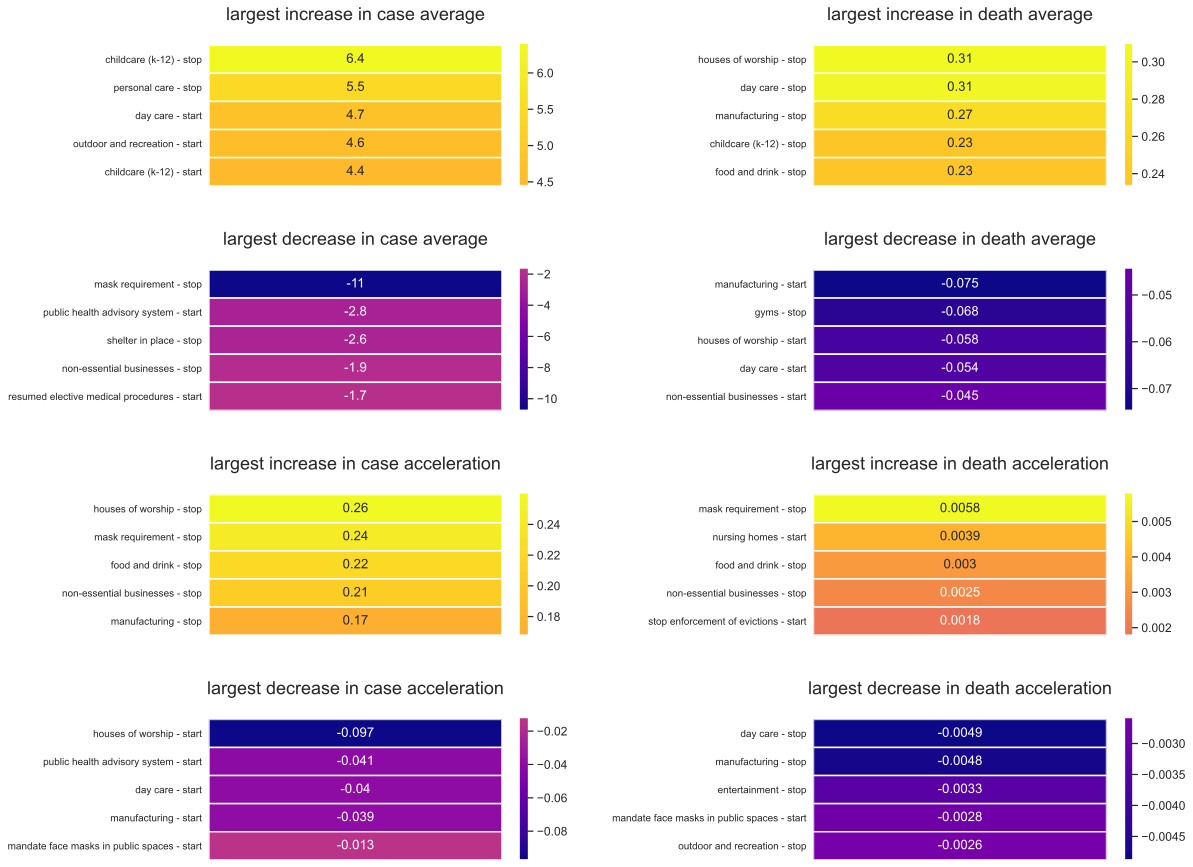

In [59]:
dfs_case = [delta_stats.sort_values(by="case_avg", ascending=False)[["case_avg"]].head(),
       delta_stats.sort_values(by="case_avg", ascending=True)["case_avg"].head(), 
       delta_stats.sort_values(by="case_accel_avg", ascending=False)["case_accel_avg"].head(),
       delta_stats.sort_values(by="case_accel_avg", ascending=True)["case_accel_avg"].head()]

dfs_death = [delta_stats.sort_values(by="death_avg", ascending=False)["death_avg"].head(),
       delta_stats.sort_values(by="death_avg", ascending=True)["death_avg"].head(), 
       delta_stats.sort_values(by="death_accel_avg", ascending=False)["death_accel_avg"].head(),
       delta_stats.sort_values(by="death_accel_avg", ascending=True)["death_accel_avg"].head()]


titles_case = [
    "largest increase in case average\n",
    "largest decrease in case average\n",
    "largest increase in case acceleration\n",
    "largest decrease in case acceleration\n", 
]

titles_death = [
    "largest increase in death average\n", 
    "largest decrease in death average\n", 
    "largest increase in death acceleration\n", 
    "largest decrease in death acceleration\n"
]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
plt.subplots_adjust(hspace=0.6, wspace=0.65, left=0)
sns.set(font_scale=1.1)

for i in range(len(ax[:,0])): 
        handles = sns.heatmap(np.asarray(dfs_case[i]).reshape(5,1), 
                              yticklabels=dfs_case[i].index, 
                              xticklabels="",
                              ax=ax[i,0], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma",
                              center = 0, 
                              linewidths=1.5
                             )
        ax[i,0].set_title(titles_case[i], fontsize=18)
        
        handles = sns.heatmap(np.asarray(dfs_death[i]).reshape(5,1), 
                              yticklabels=dfs_death[i].index,
                              xticklabels="", 
                              ax=ax[i,1], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma", 
                              center = 0,
                              linewidths=1.5
                             )
        ax[i,1].set_title(titles_death[i], fontsize=18)

# 3.3 Discussion

There are several rather interesting observations from these heatmaps. I'll discuss just a few of them here. 

- 3 heatmaps have only the start or stop of a policy: 

    * largest increase in death average (stop)
    
    * largest increase in case acceleration (stop)
    
    * larggest decrease in case acceleration (start) 


- Policies ranked highest on some heatmaps have a much higher value (> 2x) than the second place spot

    * stopping mask requirements in largest decrease in case average
    
    * starting policies related to houses of worship and largest decrease in case acceleration
    
    
- There are several policies ranked highly in multiple heatmaps

    * Stopping policies related to houses of worship are correlated with the largest increase in case acceleration and death average 
    
    * Starting these policies are correlated with the largest decrease in case acceleration by a large margin as well as an increase in case acceleration. 


- Mask requirements are represented in several different spots: 
    
    * Starting policies related to mask requirements in public spaces are correlated with a decrease in both case and death acceleration
    
    * Stopping mask requirements are correlated with the largest decrease in case average, an increase in case acceleration, and the largest increase in death acceleration.
    
    
- Shelter-in-place orders are correlated with the largest decrease in case average. 

It is vitally important to remember the correlation =/= causation. For example, even though closing houses of worship is correlated with the largest decrease in case acceleration, the does not mean that closing houses of worship CAUSED the largest decrease in case acceleration. There are many, many variables involved. 

## 3.4 Future work / linear regression

It should be possible to use a linear regression algorithm to "uncouple" these multiple policies to estimate the contribution that each policy type had to easing or worsening the case / death rates. When implementing this, my first thought is to try a model such as this: 

$$c(d) = \sum_{all policies} P_{i} \omega_{i}f(\delta d)$$

Where 
- $c(d)$ = the case or death rate acceleration on a specified day in any given county $d$
- $P_{i}$ is 1 if the policy was enacted in the county or state $\delta d$ days before the date of interest, 0 if not
- $\omega_{i}$ = the impact weight of an enacted policy
- $f(\delta d)$ = the time weight- a function that accounts for the time delay between policy enactment and change in cases. This should be a minimum 1 day after policy enactment and increases until the "golden zone" where the policy is most effective. 

This would constitute a system of equations for one equation for each row of the covid-19 case / policy dataframe, or about 800,000 equations. Not counting the 'time weight', this would be paired with 57 policy types, wich is easily solvable with linear regression. The time weight may introduce complexities into the model, as the linear regression algorithm would be solving for $\omega_{i}f(\delta d)$, so selecting $f(\delta d)$ to be a continuous function may result in solving for too many unknowns. The time weight could be chosen for specific time windows, for example 1-7 days, 7-14 day, 14-21 days, and 21+ days and may or may not change between policies. 


At the moment, my priority is to build as many projects as I can, as since I've already spent more time messing with this one than I intended, I'll be putting the linear regression implementation on the back burner until March of 2021. During that time I'll be taking a course in applied artificial intelligence, in which I hope to learn the tools necessary to implement this final step. 

For those interested in seeing this kind of linear regresstion in action, I would suggest reading the paper by [Klimek et al.](https://www.nature.com/articles/s41562-020-01009-0?fbclid=IwAR2fnHNxYtB54oHuyQmz8rEpuypgwvbWvSnY8fOQg7Zt_bLA13HsZZvecrY) which used 4 different computational methods to correlate the case case and policy data at the international scale. 

# 4. Conclusion


To summarize, we cleaned 2 datasets: one on the covid-19 case and death numbers and another on the policy data. We plotted the case data at the country and state level and correlated those with policy implementations. Finally, we more elegantly correlated the policies with case data by aggregating all the policy implementations to get a measure on the change in cases and deaths, as well as how fast those case and death numbers are changing (acceleration). 